<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

DIGHUM160 - Critical Digital Humanities<br>
Digital Hermeneutics<br>
Week 4-2: Language Biases <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

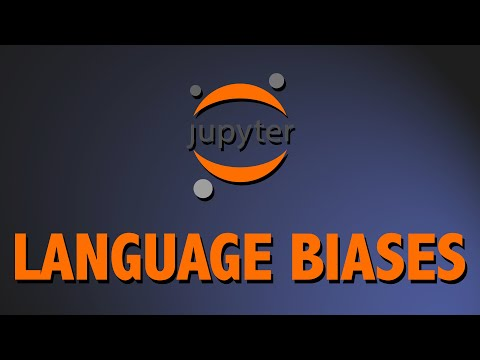

In [93]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('TIDejQEF7jY', width=640, height=360)

## Tracing Language Biases using Word Embeddings
Language carries implicit biases, functioning both as a reflection and a perpetuation of stereotypes that people carry with them. Using Natural Language Processing tools, we can trace these biases in the many language datasets to be found online.

One way to discover language biases is done using word embeddings. In order to do so, we first need to postulate concepts such as "male" or "female", both of which include a number of word vectors. Using these so-called *target concepts*, we can then compute relative similarities of other word vectors – particularly, words that act as evaluative attributes such as "strong" and "sensitive". 

These words can be categorised through clustering algorithms and labeled through a semantic analysis system into more general (conceptual) biases, yielding a broad picture of the biases present in a discourse community.

See [here](https://xfold.github.io/WE-GenderBiasVisualisationWeb/) for a web demo
and [here](https://github.com/xfold/LanguageBiasesInReddit) for the full repo.

In [76]:
import math
from textblob import TextBlob as tb
import nltk
from nltk.corpus import stopwords
import re
import gensim 
from gensim.models import Word2Vec
import pandas as pd
import logging
import os
import time
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# NOTE: This notebook only works with Gensim v4!
print(gensim.__version__)

4.2.0


In [ ]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir("../../Data")

Let's get the Word Embeddings model we made in the previous notebook.

In [78]:
model = Word2Vec.load('aita_com.emb')

## Get biased words

We now run our method of finding biased words towards our target sets.

Given a vocabulary and two sets of target words (such as, in this case, those for *women* and *men*, we rank the words from least to most biased. As such, we obtain two ordered lists of the most biased words towards each target set, obtaining an overall view of the bias distribution in that particular community with respect to those two target sets. 

Here's what happening in the next block of code:
- We calculate the centroid of a target set by averaging the embedding vectors in our target set (e.g. the vectors for `he, son, his, him, father, male` for our target concept `male`);
- We calculate the cosine similarity between the vectors for all words in our vocabulary as compared to our two centroids (we also apply POS-filtering to only work with parts of speech we expect to be relevant);
- We use a threshold based on standard deviation to determine how severe a bias needs to be before we include it;
- We rank the words in the vocabulary of our Word Embeddings model based on their bias towards either target concept.


In [79]:
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from operator import itemgetter
from scipy import spatial
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
import inflect
import numpy as np
import statistics
import itertools

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
import statistics

def _calculate_centroid(model, wordlist):
    '''
    Calculate centroid of the wordlist list of words based on the model embedding vectors
    '''
    centr = np.zeros( len(model.wv[wordlist[0]]) )
    for w in wordlist:
        centr += np.array(model.wv[w])
    return centr/len(wordlist)

def _keep_only_model_words(model, words):
    aux = [ word for word in words if word in model.wv.index_to_key]
    return aux

def _get_word_freq(model, word):
    if word in model.wv.index_to_key:
        index = model.wv.key_to_index[word]
        count = model.wv.get_vecattr(word, "count")
        return [word, count, index]
    return None

def _get_model_min_max_rank(model):
    minF = 999999
    maxF = -1
    for w in model.wv.index_to_key:
        rank = model.wv.key_to_index[w]
        if(minF>rank):
            minF = rank
        if(maxF<rank):
            maxF = rank
    return [minF, maxF]

sid = SentimentIntensityAnalyzer()
def _get_sentiment(word):
    return sid.polarity_scores(word)['compound']

'''
Normalises a value in the positive space
'''    
def _normalise(val, minF, maxF):
    #print(val, minF, maxF)
    if(maxF<0 or minF<0 or val<0):
        raise Exception('All values should be in the positive space. minf: {}, max: {}, freq: {}'.format(minF, maxF, val))
    if(maxF<= minF):
        raise Exception('Maximum frequency should be bigger than min frequency. minf: {}, max: {}, freq: {}'.format(minF, maxF, freq))
    val -= minF
    val = val/(maxF-minF)
    return val

def _get_cosine_distance(wv1, wv2):
    return spatial.distance.cosine(wv1, wv2)

def _get_min_max(dict_value):
    l = list(dict_value.values())
    return [ min(l), max(l)]

def _find_stdev_threshold_sal(dwords, stdevs):
    '''
    dword is an object like {'word':w, 'bias':bias, 'biasW':biasW, 'freq':freq, 'freqW':freqW, 'sal':val, 'wv':wv, 'sent':sent }
    stdevs : minimum stdevs for which we want to compute the threshold

    returns
    outlier_thr : the threshold correpsonding to stdevs considering salience values from the dwrods object list
    '''
    allsal = []
    for obj in dwords:
        allsal.append(obj['sal'])
    stdev = statistics.stdev(allsal)
    outlier_thr = (stdev*stdevs)+sum(allsal)/len(allsal)
    return outlier_thr

def calculate_biased_words(model, targetset1, targetset2, stdevs, 
                         acceptedPOS = ['JJ', 'JJS', 'JJR','NN', 'NNS', 'NNP', 'NNPS','VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ' ], 
                         words = None, force=False):
    '''
    this function calculates the list of biased words towards targetset1 and taregset2 with salience > than the 
    specified times (minstdev) of standard deviation.

    targetset1 <list of strings> : target set 1
    targetset2 <list of strings> : target set 2
    minstdev int : Minium threhsold for stdev to select biased words
    acceptedPOS <list<str>> : accepted list of POS to consider for the analysis, as defined in NLTK POS tagging lib. 
                              If None, no POS filtering is applied and all words in the vocab are considered
    words list<str> : list of words we want to consider. If None, all words in the vocab are considered
    '''
    if(model is None):
        raise Exception("You need to define a model to estimate biased words.")
    if(targetset1 is None or targetset2 is None):
        raise Exception("Target sets are necessary to estimate biased words.")
    if(stdevs is None):
        raise Exception("You need to define a minimum threshold for standard deviation to select biased words.")
   
    tset1 = _keep_only_model_words(model, targetset1) # remove target set words that do not exist in the model
    tset2 = _keep_only_model_words(model, targetset2) # remove target set words that do not exist in the model

    # We remove words in the target sets, and also their plurals from the set of interesting words to process.
    engine = inflect.engine()
    toremove = targetset1 + targetset2 + [engine.plural(w) for w in targetset1] + [engine.plural(w) for w in targetset2]
    if(words is None):
        words = [w for w in list(model.wv.index_to_key) if w not in toremove]

    # Calculate centroids 
    tset1_centroid = _calculate_centroid(model, tset1)
    tset2_centroid = _calculate_centroid(model, tset2)
    [minR, maxR] = _get_model_min_max_rank(model)

    # Get biases for words
    biasWF = {}
    biasWM = {}
    for i, w in enumerate(words):
        p = nltk.pos_tag([w])[0][1]
        if acceptedPOS is not None and p not in acceptedPOS:
            continue
        wv = model.wv[w]
        diff = _get_cosine_distance(tset2_centroid, wv) - _get_cosine_distance(tset1_centroid, wv)
        if(diff>0):
            biasWF[w] = diff
        else:
            biasWM[w] = -1*diff

    # Get min and max bias for both target sets, so we can normalise these values later
    [minbf, maxbf] = _get_min_max(biasWF)
    [minbm, maxbm] = _get_min_max(biasWM)

    # Iterate through all 'selected' words
    biased1 = []
    biased2 = []
    for i, w in enumerate(words):
        # Print('..Processing ', w)
        p = nltk.pos_tag([w])[0][1]
        if acceptedPOS is not None and p not in acceptedPOS:
            continue
        wv = model.wv[w]
        # Sentiment
        sent = _get_sentiment(w)
        # Rank and rank norm
        freq = _get_word_freq(model, w)[1]
        rank = _get_word_freq(model, w)[2]
        rankW = 1-_normalise(rank, minR, maxR) 

        # Normalise bias
        if(w in biasWF):
            bias = biasWF[w]
            biasW = _normalise(bias, minbf, maxbf)
            val = biasW * rankW
            biased1.append({'word':w, 'bias':bias, 'biasW':biasW, 'freq':freq, 'rank':rank, 'rankW':rankW, 'sal':val, 'wv':wv.tolist(), 'sent':sent } ) 
        if(w in biasWM):
            bias = biasWM[w]
            biasW = _normalise(bias, minbm, maxbm)
            val = biasW * rankW
            biased2.append({'word':w, 'bias':bias, 'biasW':biasW, 'freq':freq, 'rank':rank, 'rankW':rankW, 'sal':val, 'wv':wv.tolist(), 'sent':sent } ) 

    # Calculate the salience threshold for both word sets, and select the list of biased words (i.e., which words do we discard?)
    stdevs1_thr = _find_stdev_threshold_sal(biased1, stdevs)
    stdevs2_thr = _find_stdev_threshold_sal(biased2, stdevs)
    # biased1.sort(key=lambda x: x['sal'], reverse=True)
    b1_dict = {}
    for k in biased1:
        if(k['sal']>=stdevs1_thr):
            b1_dict[k['word']] = k
    # biased2.sort(key=lambda x: x['sal'], reverse=True)
    b2_dict = {}
    for k in biased2:
        if(k['sal']>=stdevs2_thr):
            b2_dict[k['word']] = k

    #transform centroid tol list so they become serializable
    tset1_centroid = tset1_centroid.tolist() 
    tset2_centroid = tset2_centroid.tolist()
    return [b1_dict, b2_dict]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tomvannuenen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/tomvannuenen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Getting similar words through the WE model can help us find words for our "target sets"--i.e., the conceptual entities such as "man" and "woman" we want to check biases against.

In [80]:
# get similar words
sims = model.wv.most_similar('asshole', topn=10)  # get other similar words
sims

[('assholeishness', 0.5542088747024536),
 ('ta', 0.5381892919540405),
 ('esh.your', 0.49919262528419495),
 ('ytais', 0.4884131848812103),
 ('nahyou’re', 0.48837530612945557),
 ('fuckwad', 0.4863407611846924),
 ('ytfa', 0.48545175790786743),
 ('here**|**esh****no_hole_here**|**nah****not', 0.4747871458530426),
 ('redflag', 0.46845439076423645),
 ('ytain', 0.4670969545841217)]

## Setting the target sets - CHANGE THIS PART for your own research!

Here we create the two target sets, called `t1` and `t2`. These two lists are the ones you'll want to swap out if you are going to create your own target sets to find biases!

See the **bottom of this notebook** for details on different existing target sets (about gender, religion, racial, career/family and arts/science). If you want to go further, see e.g. [this paper](https://dl.acm.org/doi/10.1145/3366424.3383560) on how to define political biases, which you could adapt for your own purposes. 

You can also come up with **your own word sets** if you want to explore other kinds of biases. Feel free to touch base with me if you want to discuss!

In [81]:
# Note that target set 1 is about femininity/women, and target set 2 about masculinity/men

t1=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
t2=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 

[b1, b2] = calculate_biased_words(model, t1, t2, 4)

Let's print some biases. Here you see the most-biased words towards our target concepts (1 being *women*, 2 being *men*).

In [82]:
print('Biased words towards target set 1')
print( [w for w in b1.keys()] )
print()
print('Biased words towards target set 2')
print( [w for w in b2.keys()] )

Biased words towards target set 1
['choice', 'involve', 'abusive', 'shame', 'fit', 'bet', 'insecure', 'photo', 'potential', 'zero', 'block', 'teen', 'supportive', 'trauma', 'gain', 'painful', 'escalate', 'social_medium', 'remain', 'pursue', 'incident', 'commenter', 'overweight', 'method', 'intent', 'controlling', 'self_esteem', 'route', 'cross_line', 'rejection', 'childbirth', 'retaliate', 'workout', 'shaming', 'appeal', 'stalker', 'bash', 'douchey']

Biased words towards target set 2
['play', 'hand', 'stand', 'pick', 'bear', 'bathroom', 'plenty', 'split', 'separate', 'punishment', 'bro', 'quiet', 'mate', 'uncle', 'video_game', 'pride', 'spectrum', 'goodbye', 'incapable', 'fyi', 'anniversary', 'tonight', 'sin', 'misread', 'saying', 'permit', 'cure', 'xbox']


## Clustering similar words (K-means + silhouette)

Here,  we group our language biases in more general clusters. We do so using the K-means clustering algorithm, and use silhouette scores to validate the consistency within our clusters of data. 

In general, this results in words with similar meanings being clustered together. Clustering allows the biased words to be better interpretable, as their context becomes clearer. 

In [83]:
import pandas as pd
import gensim
import nltk.data
import numpy as np
from scipy import spatial
from sklearn.cluster import KMeans
import sklearn

'''
TARGET SET 1
'''
t1_embeddings = [b1[w]['wv'] for w in b1] # t1 embeddings = list of embeddings of words biased towards target set 1
t1_words = [w for w in b1.keys()]

# Clustering
rangek = range(2, int((len(t1_embeddings)/2)-1) ) # Clusters should be min size 2 at max half of the amount of words (speeding up + forcing clusters)
print('[Testing', rangek, 'clusters]')
kmeans_p = [ KMeans(n_clusters=k).fit_predict(t1_embeddings) for k in rangek] 
kmeans_sil = [ sklearn.metrics.silhouette_score(t1_embeddings, labels) for labels in kmeans_p] 
print('[Silhouette values', kmeans_sil)
indexmaxsil =  kmeans_sil.index(max(kmeans_sil))
print('[Max silhouette, ', max(kmeans_sil), '; index_k: ',indexmaxsil,']')

# Aggregating all clusters from same index in list
clusters1 = {}
for i, index in enumerate(kmeans_p[indexmaxsil]): # returns list of cluster index, telling you which cluster each word belongs to 
    if(index in clusters1):
        clusters1[index].append(t1_words[i])
    else:
        clusters1[index]  = [t1_words[i]]
        
        
'''
TARGET SET 2
'''
t2_embeddings = [b2[w]['wv'] for w in b2]
t2_words = [w for w in b2.keys()]

# Clustering
rangek = range(2, int((len(t2_embeddings)/2)-1) )
print('[Testing', rangek, 'clusters]')
kmeans_p = [ KMeans(n_clusters=k).fit_predict(t2_embeddings) for k in rangek ] 
kmeans_sil = [ sklearn.metrics.silhouette_score(t2_embeddings, labels) for labels in kmeans_p] 
print('[Silhouette values', kmeans_sil)
indexmaxsil =  kmeans_sil.index(max(kmeans_sil))
print('[Max silhouette, ', max(kmeans_sil), '; index_k: ',indexmaxsil,']')

clusters2 = {}
for i, index in enumerate(kmeans_p[indexmaxsil]):
    if(index in clusters2):
        clusters2[index].append(t2_words[i])
    else:
        clusters2[index]  = [t2_words[i]]

[Testing range(2, 18) clusters]
[Silhouette values [0.07343348750952834, 0.010363721815709747, -0.006893166879662333, 0.01485671656419698, 0.008386512159411096, -0.0025629760459694386, 0.0160663754291767, 0.017986868129772637, 0.015495879787465661, -0.008365818100892824, 0.014300987977273168, 0.007813294662100043, -0.0011161919203560903, 0.011419773888395338, 0.01577652519080459, 0.0058742483712985955]
[Max silhouette,  0.07343348750952834 ; index_k:  0 ]
[Testing range(2, 13) clusters]
[Silhouette values [0.02274946718247301, 0.05643795970468296, 0.028625416611476523, 0.04365165937065364, 0.0457509214209612, 0.029251628323508545, 0.029803980001471855, 0.03648897054645383, 0.03087519304517017, 0.012412647970473062, 0.017822169406476775]
[Max silhouette,  0.05643795970468296 ; index_k:  1 ]


Let's print the clusters we've got.

In [84]:
print('Clusters target set 1')
print( list( clusters1.values()) )        

print('Clusters target set 2')
print( list( clusters2.values()) )        

Clusters target set 1
[['choice', 'involve', 'abusive', 'shame', 'fit', 'bet', 'insecure', 'photo', 'potential', 'zero', 'block', 'teen', 'supportive', 'trauma', 'gain', 'escalate', 'social_medium', 'remain', 'pursue', 'incident', 'commenter', 'overweight', 'method', 'intent', 'controlling', 'self_esteem', 'route', 'cross_line', 'rejection', 'retaliate', 'shaming', 'appeal', 'stalker', 'bash', 'douchey'], ['painful', 'childbirth', 'workout']]
Clusters target set 2
[['play', 'hand', 'stand', 'pick', 'bear', 'bathroom', 'plenty', 'split', 'separate', 'punishment', 'bro', 'quiet', 'mate', 'uncle', 'pride', 'spectrum', 'goodbye', 'incapable', 'fyi', 'anniversary', 'tonight', 'misread', 'saying', 'permit', 'cure'], ['video_game', 'xbox'], ['sin']]


## Visualise using t-SNE

In [85]:
# prepare the datat for the tsne in order to create the plot

labels1 = [] # labels = words
y1 = []
embs1 = []
for k in clusters1:
    labels1 += clusters1[k]
embs1 = [model.wv[j] for j in labels1]
y1 = len(labels1)*[0]

labels2 = []
y2 = []
embs2 = []
for k in clusters2:
    labels2 += clusters2[k]
embs2 = [model.wv[j] for j in labels2]
y2 = len(labels2)*[1]

labels = labels1 +labels2
y      = y1 +y2
embs   = embs1 + embs2


/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/tomvannuenen/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


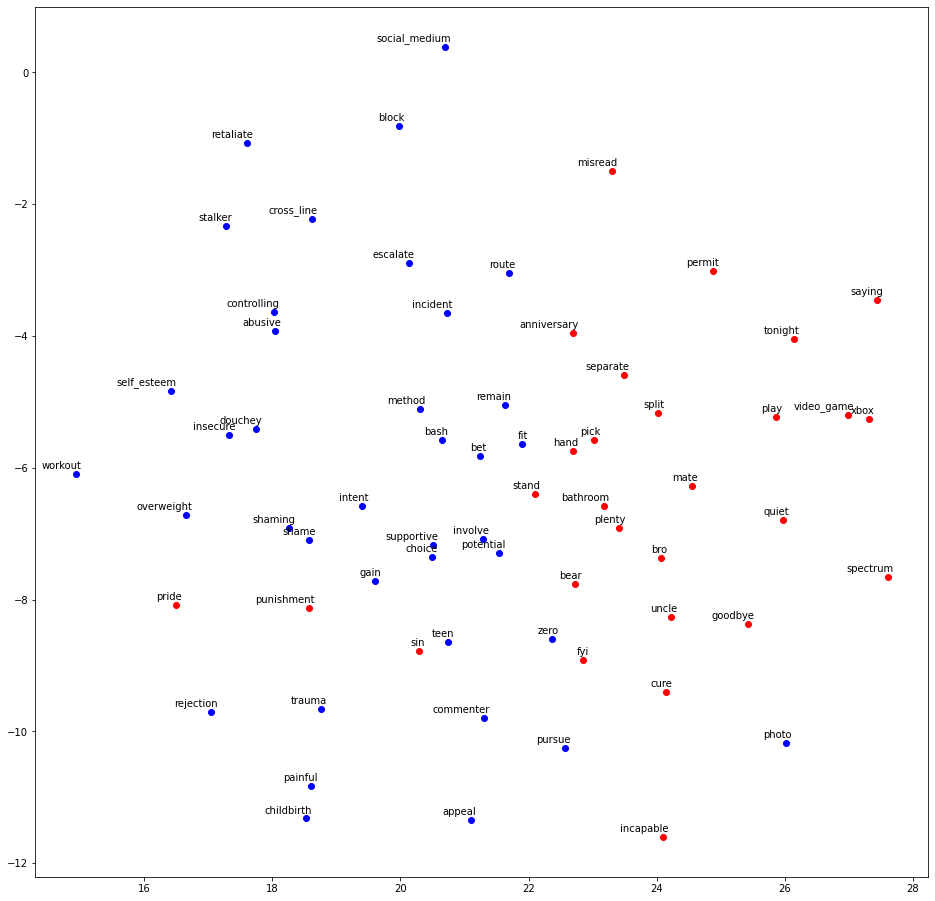

In [92]:
# Note: the tsne should be estimated for all words in the model, otherwise the tsne dimensions won't be correct
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# if words appear very close together, change random state to obtain better visual representations
# dimensional reduction of T-SNE can be done through different ways; random_state determines which is taken
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=42)
X_tsne = tsne.fit_transform(embs) # X_tsne = [[1,2], [3,4], [5,6]]


# split the X and Y coordinates
embsx = [x[0] for x in X_tsne]
embsy = [x[1] for x in X_tsne]
color = ['blue' if i == 0 else 'red' for i in y]

plt.figure(figsize=(16, 16)) 
for i in range(len(embs)):
    plt.scatter(embsx[i],embsy[i], c=color[i])
    plt.annotate( labels[i],
                  xy=(embsx[i],embsy[i]),
                  xytext=(6, 3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
plt.show()

## Concordances of most-biased words

We might want to engage in further analysis of the most interesting biased words in our data. To do so, let's reach back to the tools we looked at in the beginning of this course.

Using NLTK, we can create a concordance view of the context in which the biased words appear.

In [87]:
# Let's first get our comments DF and put the comments in a long list.
df = pd.read_csv('aita_com_top.csv')

In [88]:
# Create an NLTK Text object--this may take a while
from nltk.text import Text

total = []
for row in df['body']:
    total.extend(row.split(' '))
t = Text(total)    

The following function takes in our tokens list and our biased words. It allows a user to select a target set, then type in a word from that target set (recall that target set 1 involves the biased words towards women, and target set 2 the biases towards men). The function will then print out the concordances of the chosen word. 

Use this function if you want to explore some of the biased words you found!

In [89]:
def concordance_viewer(tokens,b1,b2,width=115,top=10, lines=30):
    # sort by rank
    b1_sort = sorted(b1.items(), key=lambda x: x[1]['rank'], reverse=False)
    b2_sort = sorted(b2.items(), key=lambda x: x[1]['rank'], reverse=False)
  
    while True:
        t_inp = input("See biased words towards target set 1 or 2?")
        if t_inp == "1":
            target = b1_sort
            break
        elif t_inp == "2":
            target = b2_sort
            break
        else:
            print("Please type 1 or 2")

    # print most biased words
    print("{: >15} {: >5}".format('WORD','RANK'))
    for i in target[:top]:
        row = [i[1]['word'], i[1]['rank']]
        print("{: >15} {: >5}".format(*row))
    word_inp = input("Pick a biased word from the above list to see concordances:")
    tokens.concordance(word_inp, width=width, lines=lines)

concordance_viewer(t,b1, b2)

See biased words towards target set 1 or 2? 1


           WORD  RANK
         choice   148
        involve   325
        abusive   400
          shame   567
            fit   575
            bet   586
       insecure   691
          photo   750
      potential   779
           zero   791


Pick a biased word from the above list to see concordances: involve


Displaying 30 of 422 matches:
e a hundred ways to resolve the situation that didn't involve hitting somebody, none if which he took advantage of.
nyway. It's hard to have adult friendships that don't involve partners at all so, for the sake of your partner, you
ng* clever, next round. The worst secret hitler games involve a group of people failing to get the point of decepti
'jokes' she says to you.  Especially as they directly involve you.

Personally, I would try to talk to her about it
, even if it means bursting her bubble.  >He tried to involve me a few times but I was getting upset so I didn't.




He not only went to the party for you, but tried to involve you in the conversation and you refused. He probably 
u feel something doesn′t make you right. >He tried to involve me a few times

That's your fault, not his.

If he ha
friend, WHILE YOU ARE THERE, while they are TRYING to involve you, you're going to lose both BFs and friends left a
 and is making arrangements to secure them

## Existing target sets - use these instead of the 

*Gender target sets taken from Nosek, Banaji, and Greenwald 2002.*

Female: `sister, female, woman, girl, daughter, she, hers, her`.

Male: `brother, male, man, boy, son, he, his, him`.


*Religion target sets taken from Garg et al. 2018.*

Islam: `allah, ramadan, turban, emir, salaam, sunni, koran, imam, sultan, prophet, veil, ayatollah, shiite, mosque, islam, sheik, muslim, muhammad`.

Christianity: `baptism, messiah, catholicism, resurrection, christianity, salva-tion, protestant, gospel, trinity, jesus, christ, christian, cross,catholic, church`.

*Racial target sets taken from Garg et al. 2017*

White last names: `harris, nelson, robinson, thompson, moore, wright, anderson, clark, jackson, taylor, scott, davis, allen, adams, lewis, williams, jones, wilson, martin, johnson`.

Hispanic last names: `ruiz, alvarez, vargas, castillo, gomez, soto,gonzalez, sanchez, rivera, mendoza, martinez, torres, ro-driguez, perez, lopez, medina, diaz, garcia, castro, cruz`.

Asian last names: `cho, wong, tang, huang, chu, chung, ng,wu, liu, chen, lin, yang, kim, chang, shah, wang, li, khan,singh, hong`.

Russian last names: `gurin, minsky, sokolov, markov, maslow, novikoff, mishkin, smirnov, orloff, ivanov, sokoloff, davidoff, savin, romanoff, babinski, sorokin, levin, pavlov, rodin, agin`.


*Career/family target sets taken from Garg et al. 2018.*

Career: `executive, management, professional, corporation, salary, office, business, career`.

Family: `home, parents, children, family, cousins, marriage, wedding, relatives.Math: math, algebra, geometry, calculus, equations, computation, numbers, addition`.


*Arts/Science target sets taken from Garg et al. 2018.*

Arts: `poetry, art, sculpture, dance, literature, novel, symphony, drama`.

Science: `science, technology, physics, chemistry, Einstein, NASA, experiment, astronomy`.

### Sources

Nosek, B. A., Banaji, M. R., & Greenwald, A. G. (2002). Harvesting implicit group attitudes and beliefs from a demonstration web site. Group Dynamics, 6(1), 101–115. https://doi.org/10.1037/1089-2699.6.1.101

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2017). Word Embeddings Quantify 100 Years of Gender and Ethnic Stereotypes, 1–33.